In [1]:
import pandas as pd
import numpy as np
from preprocessing.dataset import EEGDataModule
from preprocessing.standardization import EEGPreprocessor, normalize_features
import torch

In [2]:
path = '../data/BEED_Data.csv'

In [3]:
df = pd.read_csv(path)

In [4]:
print("=== Loading and Examining Data ===")
data = pd.read_csv(path)
print(f"Original data shape: {data.shape}")
print(f"Columns: {list(data.columns)}")

=== Loading and Examining Data ===
Original data shape: (8000, 17)
Columns: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'y']


In [5]:
data_normalized = normalize_features(data, method='zscore')  # Standard scaling

data_normalized = data.copy()

In [6]:
preprocessor = EEGPreprocessor(
    scaler_type='standard',  # 'standard', 'minmax', or 'robust'
    apply_pca=False,         # dimensionality reduction
    n_components=None,     
    remove_outliers=False,   
    outlier_threshold=3.0    # Z-score threshold for outlier detection
)


In [7]:
data_transformed = preprocessor.fit_transform(data_normalized)
print(f"Transformed data shape: {data_transformed.shape}")

preprocessing_info = preprocessor.get_preprocessing_info()
print(f"Preprocessing info: {preprocessing_info}")

Fitting preprocessor with standard scaler
Transformed data shape: (8000, 17)
Preprocessing info: {'scaler_type': 'standard', 'apply_pca': False, 'n_features_original': 16, 'is_fitted': True, 'feature_names': ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16']}


In [8]:
print("\n=== Creating Data Loaders ===")
data_module = EEGDataModule(
    path,
    test_size=0.2,
    val_size=0.2,
    batch_size=32,
    random_state=42
)
train_loader, val_loader, test_loader = data_module.get_data_loaders()


=== Creating Data Loaders ===
Loading data from ../data/BEED_Data.csv
Loaded 8000 samples
Train set: 5120 samples
Validation set: 1280 samples
Test set: 1600 samples
Dataset created with 5120 samples and 16 features
Feature columns: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16']
Target distribution: [1280 1280 1280 1280]
Dataset created with 1280 samples and 16 features
Feature columns: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16']
Target distribution: [320 320 320 320]
Dataset created with 1600 samples and 16 features
Feature columns: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16']
Target distribution: [400 400 400 400]
Created data loaders with batch size 32


In [9]:
print("\n=== Verifying Data Loaders ===")
for batch_idx, (data_batch, target_batch) in enumerate(train_loader):
    print(f"Training batch {batch_idx + 1}:")
    print(f"  Data shape: {data_batch.shape}")
    print(f"  Target shape: {target_batch.shape}")
    print(f"  Data range: [{data_batch.min():.3f}, {data_batch.max():.3f}]")
    print(f"  Target values: {torch.unique(target_batch).tolist()}")
    break

for batch_idx, (data_batch, target_batch) in enumerate(test_loader):
    print(f"Test batch {batch_idx + 1}:")
    print(f"  Data shape: {data_batch.shape}")
    print(f"  Target shape: {target_batch.shape}")
    print(f"  Data range: [{data_batch.min():.3f}, {data_batch.max():.3f}]")
    print(f"  Target values: {torch.unique(target_batch).tolist()}")
    break



=== Verifying Data Loaders ===
Training batch 1:
  Data shape: torch.Size([32, 16])
  Target shape: torch.Size([32])
  Data range: [-124.000, 147.000]
  Target values: [0, 1, 2, 3]
Test batch 1:
  Data shape: torch.Size([32, 16])
  Target shape: torch.Size([32])
  Data range: [-174.000, 168.000]
  Target values: [0, 1, 2, 3]


In [10]:
from utils.losses import calculate_class_weights
from utils.metrics import ClassificationMetrics
from utils.optimizers import get_adam_config, create_optimizer_scheduler
from loops.train import train_model
from loops.test import test_model

In [11]:
print("Calculating class weights...")
class_weights = calculate_class_weights(train_loader)
print(f"Class weights: {class_weights}")

Calculating class weights...
Class weights: tensor([1., 1., 1., 1.])


In [12]:
from models.custom import CustomModel

model = CustomModel(num_classes=4, input_channels=16)

print(f"Custom model created with {sum(p.numel() for p in model.parameters()):,} parameters")
print(model)

optimizer_config = get_adam_config(lr=0.001, weight_decay=1e-5)
optimizer, scheduler = create_optimizer_scheduler(model, optimizer_config)

train_config = {
    'num_epochs': 50,
    'learning_rate': 0.001,
    'optimizer_type': 'adam',
    'loss_type': 'focal',
    'early_stopping_patience': 10,
    'use_class_weights': True,
    'save_best_model': True,
    'model_save_path': 'models/',
    'log_interval': 10,
    'loss_params': {'alpha': class_weights, 'gamma': 2.0}
}

print("\n=== Starting Training ===")
trainer = train_model(model, train_loader, val_loader, train_config, device='cpu')


Custom model created with 4,310,412 parameters
CustomModel(
  (fc1): Linear(in_features=16, out_features=64, bias=True)
  (res1): ResidualBlock(
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
    (shortcut): Identity()
  )
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (res2): ResidualBlock(
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
    (shortcut): Identity()
  )
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (res3): ResidualBlock(
    (fc1): Linear(in_features=256, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
    (shortcut): Identity()
  )
  (fc4): Linear(in_features=256, out_features=512, bias=True)
  (res4):

Epoch 1/50: 100%|██████████| 160/160 [00:05<00:00, 27.05it/s, Loss=0.2677, Acc=0.5145]



Epoch 1/50 (6.25s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.5174
Precision (Macro): 0.5121
Recall (Macro): 0.5174
F1-Score (Macro): 0.4934
Cohen's Kappa: 0.3565
Matthews Correlation: 0.3647
ROC AUC (OVR): 0.8116
ROC AUC (OVO): 0.8116

Validation Metrics:

Metrics:
Accuracy: 0.6102
Precision (Macro): 0.5249
Recall (Macro): 0.6102
F1-Score (Macro): 0.5397
Cohen's Kappa: 0.4802
Matthews Correlation: 0.5388
ROC AUC (OVR): 0.8879
ROC AUC (OVO): 0.8879

Learning Rate: 0.001000
Model saved to models/best_model.pth


Epoch 2/50: 100%|██████████| 160/160 [00:05<00:00, 31.13it/s, Loss=0.3010, Acc=0.6509]



Epoch 2/50 (5.35s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.6520
Precision (Macro): 0.6426
Recall (Macro): 0.6520
F1-Score (Macro): 0.6451
Cohen's Kappa: 0.5359
Matthews Correlation: 0.5375
ROC AUC (OVR): 0.8625
ROC AUC (OVO): 0.8625

Validation Metrics:

Metrics:
Accuracy: 0.7258
Precision (Macro): 0.7283
Recall (Macro): 0.7258
F1-Score (Macro): 0.7155
Cohen's Kappa: 0.6344
Matthews Correlation: 0.6435
ROC AUC (OVR): 0.8869
ROC AUC (OVO): 0.8869

Learning Rate: 0.001000
Model saved to models/best_model.pth


Epoch 3/50: 100%|██████████| 160/160 [00:05<00:00, 31.20it/s, Loss=0.1700, Acc=0.6819]



Epoch 3/50 (5.37s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.6820
Precision (Macro): 0.6669
Recall (Macro): 0.6820
F1-Score (Macro): 0.6683
Cohen's Kappa: 0.5760
Matthews Correlation: 0.5808
ROC AUC (OVR): 0.8806
ROC AUC (OVO): 0.8806

Validation Metrics:

Metrics:
Accuracy: 0.7695
Precision (Macro): 0.7911
Recall (Macro): 0.7695
F1-Score (Macro): 0.7743
Cohen's Kappa: 0.6927
Matthews Correlation: 0.6959
ROC AUC (OVR): 0.9033
ROC AUC (OVO): 0.9033

Learning Rate: 0.001000
Model saved to models/best_model.pth


Epoch 4/50: 100%|██████████| 160/160 [00:05<00:00, 31.01it/s, Loss=0.3159, Acc=0.7096]



Epoch 4/50 (5.52s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.7094
Precision (Macro): 0.7044
Recall (Macro): 0.7094
F1-Score (Macro): 0.7056
Cohen's Kappa: 0.6125
Matthews Correlation: 0.6134
ROC AUC (OVR): 0.8913
ROC AUC (OVO): 0.8913

Validation Metrics:

Metrics:
Accuracy: 0.6789
Precision (Macro): 0.7106
Recall (Macro): 0.6789
F1-Score (Macro): 0.6597
Cohen's Kappa: 0.5719
Matthews Correlation: 0.5957
ROC AUC (OVR): 0.9203
ROC AUC (OVO): 0.9203

Learning Rate: 0.001000


Epoch 5/50: 100%|██████████| 160/160 [00:05<00:00, 30.51it/s, Loss=0.1636, Acc=0.7132]



Epoch 5/50 (5.51s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.7141
Precision (Macro): 0.7077
Recall (Macro): 0.7141
F1-Score (Macro): 0.7095
Cohen's Kappa: 0.6188
Matthews Correlation: 0.6198
ROC AUC (OVR): 0.8931
ROC AUC (OVO): 0.8931

Validation Metrics:

Metrics:
Accuracy: 0.6633
Precision (Macro): 0.7017
Recall (Macro): 0.6633
F1-Score (Macro): 0.6435
Cohen's Kappa: 0.5510
Matthews Correlation: 0.5755
ROC AUC (OVR): 0.9230
ROC AUC (OVO): 0.9230

Learning Rate: 0.001000


Epoch 6/50: 100%|██████████| 160/160 [00:06<00:00, 25.75it/s, Loss=0.1855, Acc=0.7171]



Epoch 6/50 (6.50s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.7188
Precision (Macro): 0.7061
Recall (Macro): 0.7188
F1-Score (Macro): 0.7090
Cohen's Kappa: 0.6250
Matthews Correlation: 0.6276
ROC AUC (OVR): 0.8962
ROC AUC (OVO): 0.8962

Validation Metrics:

Metrics:
Accuracy: 0.7297
Precision (Macro): 0.7405
Recall (Macro): 0.7297
F1-Score (Macro): 0.7179
Cohen's Kappa: 0.6396
Matthews Correlation: 0.6528
ROC AUC (OVR): 0.9080
ROC AUC (OVO): 0.9080

Learning Rate: 0.001000


Epoch 7/50: 100%|██████████| 160/160 [00:05<00:00, 31.60it/s, Loss=0.1698, Acc=0.7223]



Epoch 7/50 (5.30s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.7225
Precision (Macro): 0.7133
Recall (Macro): 0.7225
F1-Score (Macro): 0.7161
Cohen's Kappa: 0.6299
Matthews Correlation: 0.6313
ROC AUC (OVR): 0.9007
ROC AUC (OVO): 0.9007

Validation Metrics:

Metrics:
Accuracy: 0.7133
Precision (Macro): 0.7072
Recall (Macro): 0.7133
F1-Score (Macro): 0.6774
Cohen's Kappa: 0.6177
Matthews Correlation: 0.6493
ROC AUC (OVR): 0.9394
ROC AUC (OVO): 0.9394

Learning Rate: 0.001000


Epoch 8/50: 100%|██████████| 160/160 [00:04<00:00, 33.31it/s, Loss=0.2154, Acc=0.7326]



Epoch 8/50 (5.03s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.7340
Precision (Macro): 0.7220
Recall (Macro): 0.7340
F1-Score (Macro): 0.7215
Cohen's Kappa: 0.6453
Matthews Correlation: 0.6502
ROC AUC (OVR): 0.9030
ROC AUC (OVO): 0.9030

Validation Metrics:

Metrics:
Accuracy: 0.7281
Precision (Macro): 0.7243
Recall (Macro): 0.7281
F1-Score (Macro): 0.7006
Cohen's Kappa: 0.6375
Matthews Correlation: 0.6601
ROC AUC (OVR): 0.9255
ROC AUC (OVO): 0.9255

Learning Rate: 0.001000


Epoch 9/50: 100%|██████████| 160/160 [00:05<00:00, 30.67it/s, Loss=0.1833, Acc=0.7517]



Epoch 9/50 (5.46s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.7502
Precision (Macro): 0.7440
Recall (Macro): 0.7502
F1-Score (Macro): 0.7441
Cohen's Kappa: 0.6669
Matthews Correlation: 0.6692
ROC AUC (OVR): 0.9092
ROC AUC (OVO): 0.9092

Validation Metrics:

Metrics:
Accuracy: 0.7250
Precision (Macro): 0.7386
Recall (Macro): 0.7250
F1-Score (Macro): 0.7125
Cohen's Kappa: 0.6333
Matthews Correlation: 0.6488
ROC AUC (OVR): 0.9179
ROC AUC (OVO): 0.9179

Learning Rate: 0.001000


Epoch 10/50: 100%|██████████| 160/160 [00:05<00:00, 29.14it/s, Loss=0.2429, Acc=0.7603]



Epoch 10/50 (5.75s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.7611
Precision (Macro): 0.7539
Recall (Macro): 0.7611
F1-Score (Macro): 0.7546
Cohen's Kappa: 0.6815
Matthews Correlation: 0.6836
ROC AUC (OVR): 0.9179
ROC AUC (OVO): 0.9179

Validation Metrics:

Metrics:
Accuracy: 0.7086
Precision (Macro): 0.7386
Recall (Macro): 0.7086
F1-Score (Macro): 0.6942
Cohen's Kappa: 0.6115
Matthews Correlation: 0.6318
ROC AUC (OVR): 0.9273
ROC AUC (OVO): 0.9273

Learning Rate: 0.000100


Epoch 11/50: 100%|██████████| 160/160 [00:04<00:00, 35.06it/s, Loss=0.1100, Acc=0.7821]



Epoch 11/50 (4.75s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.7816
Precision (Macro): 0.7761
Recall (Macro): 0.7816
F1-Score (Macro): 0.7751
Cohen's Kappa: 0.7089
Matthews Correlation: 0.7116
ROC AUC (OVR): 0.9303
ROC AUC (OVO): 0.9303

Validation Metrics:

Metrics:
Accuracy: 0.7547
Precision (Macro): 0.7767
Recall (Macro): 0.7547
F1-Score (Macro): 0.7480
Cohen's Kappa: 0.6729
Matthews Correlation: 0.6855
ROC AUC (OVR): 0.9406
ROC AUC (OVO): 0.9406

Learning Rate: 0.000100
Early stopping triggered at epoch 11

Training completed in 61.18 seconds
Best validation metric: 0.7743 at epoch 3
Model saved to models/final_model.pth



=== Starting Testing ===
Starting testing on cpu

TEST RESULTS

Metrics:
Accuracy: 0.7531
Precision (Macro): 0.7793
Recall (Macro): 0.7531
F1-Score (Macro): 0.7456
Cohen's Kappa: 0.6708
Matthews Correlation: 0.6846
ROC AUC (OVR): 0.9375
ROC AUC (OVO): 0.9375


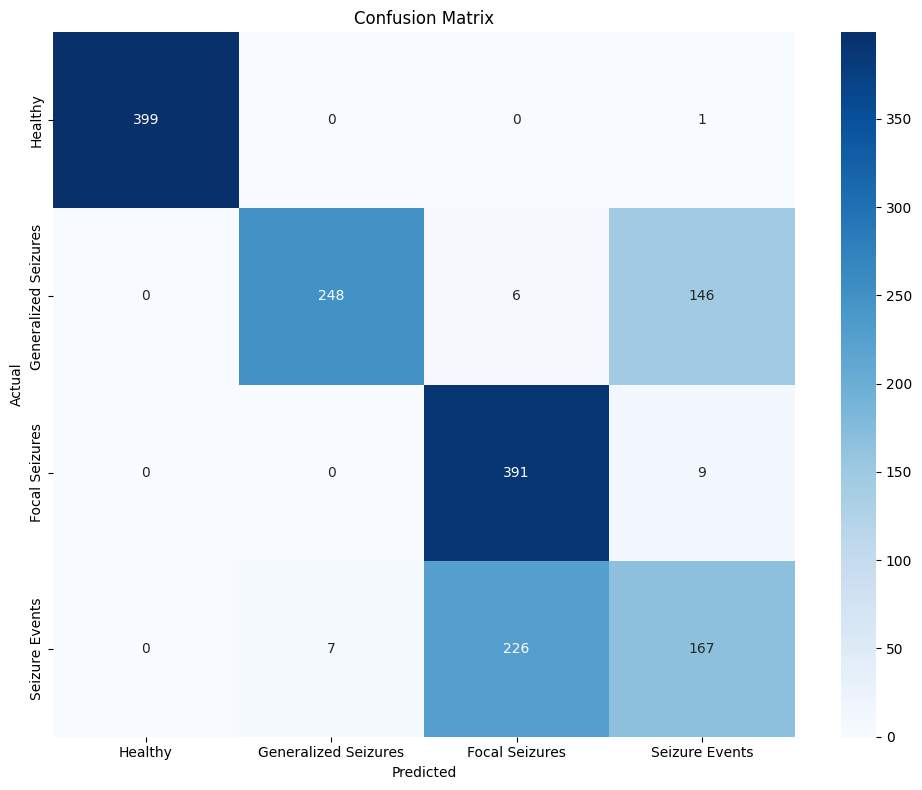

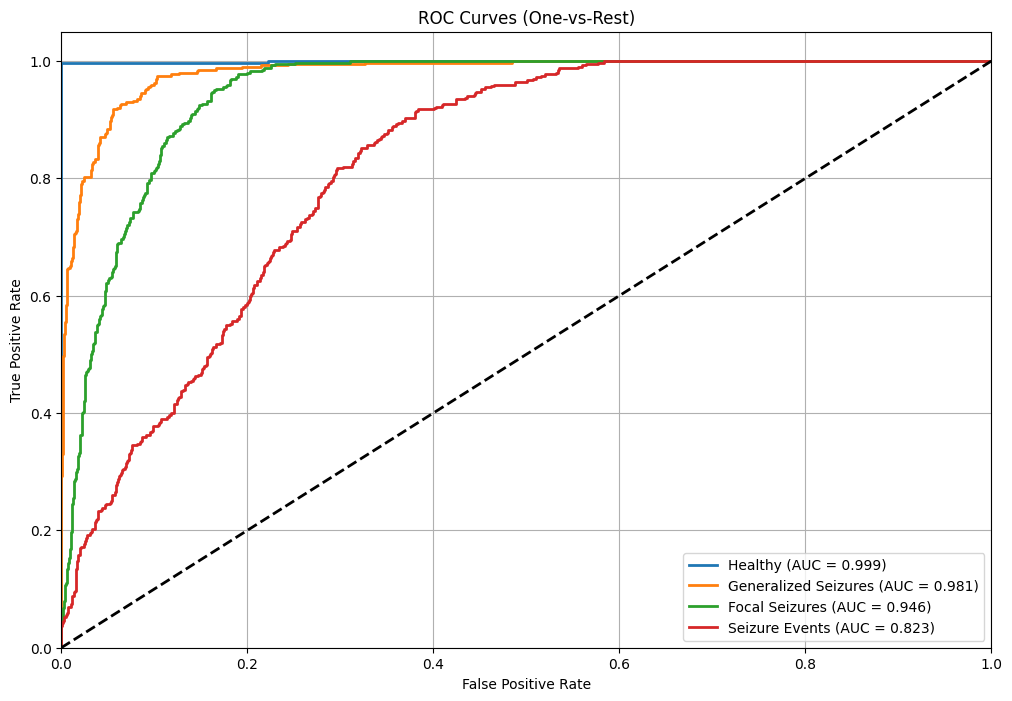

Predictions saved to results/predictions.csv

=== Final Results ===
Test Accuracy: 0.7531
Test F1 Score: 0.7456
Test Precision: 0.7793
Test Recall: 0.7531
Training history plot saved to results/training_history.png


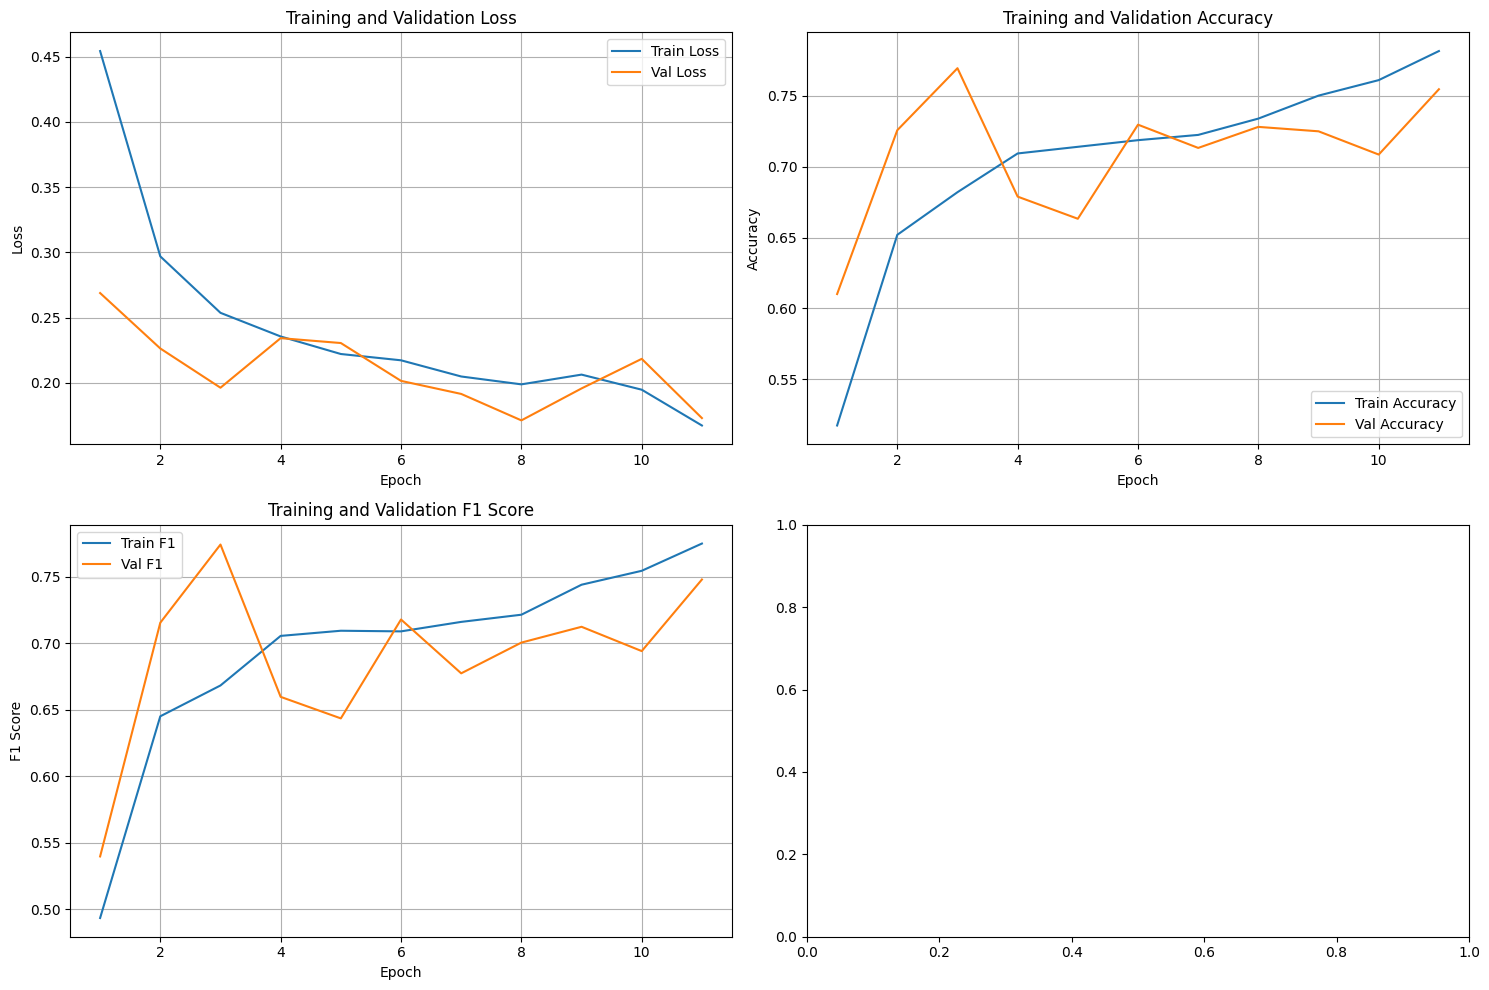

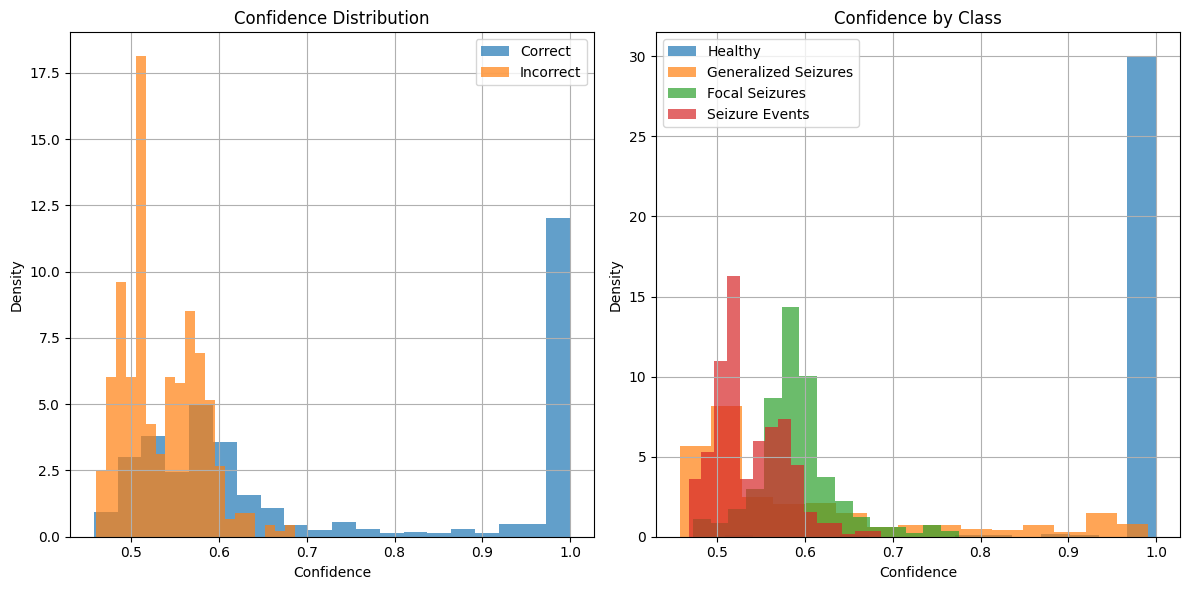

In [13]:
test_config = {
    'save_predictions': True,
    'save_confusion_matrix': True,
    'class_names': ['Healthy', 'Generalized Seizures', 'Focal Seizures', 'Seizure Events']
}

print("\n=== Starting Testing ===")
tester = test_model(model, test_loader, device='cpu', config=test_config)

print("\n=== Final Results ===")
final_metrics = tester.test_metrics.compute()
print(f"Test Accuracy: {final_metrics['accuracy']:.4f}")
print(f"Test F1 Score: {final_metrics['f1_macro']:.4f}")
print(f"Test Precision: {final_metrics['precision_macro']:.4f}")
print(f"Test Recall: {final_metrics['recall_macro']:.4f}")

trainer.plot_training_history(save_path='results/training_history.png')

tester.plot_confidence_distribution()